In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob

In [2]:
nx, ny = 9, 6
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100
ym_per_pix = 30/720
xm_per_pix = 3.7/700

In [3]:
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

In [4]:
def calibrate_camera():
    cal_images_path = "./camera_cal/*jpg"
    cal_images = glob.glob(cal_images_path)

    for idx, fname in enumerate(cal_images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    img = cv2.imread('./camera_cal/calibration1.jpg')
    img_size = (img.shape[1::-1])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    return mtx, dist

Text(0.5,1,'Undistorted Image')

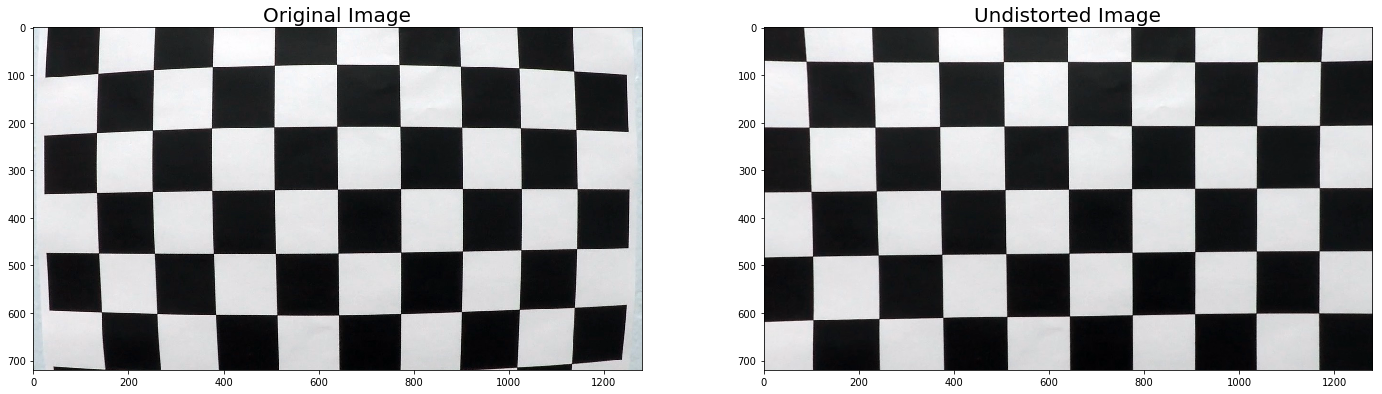

In [5]:
mtx, dist = calibrate_camera()
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

In [17]:
f.savefig('output_images/undistort.jpg')

Text(0.5,1,'Undistorted Image')

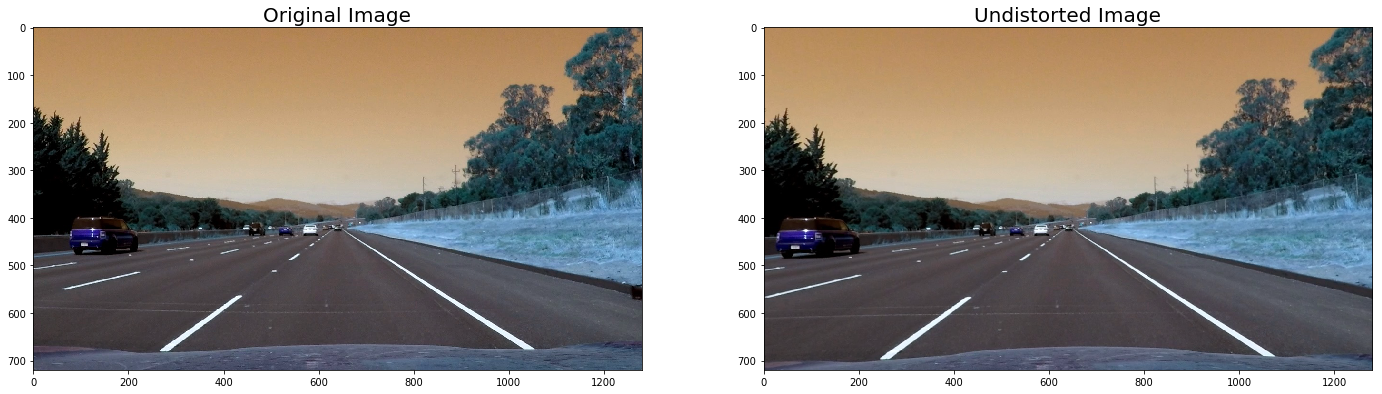

In [8]:
mtx, dist = calibrate_camera()
img = cv2.imread('test_images/straight_lines2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

In [9]:
f.savefig('output_images/undistort2.jpg')

In [18]:
def thresholding_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

In [19]:
img = cv2.imread('test_images/test4.jpg')

In [20]:
s_thresh=(170, 255)
sx_thresh=(20, 100)
color_binary, combined_binary = thresholding_pipeline(img, s_thresh, sx_thresh)

Text(0.5,1,'Thresholding Pipeline Result')

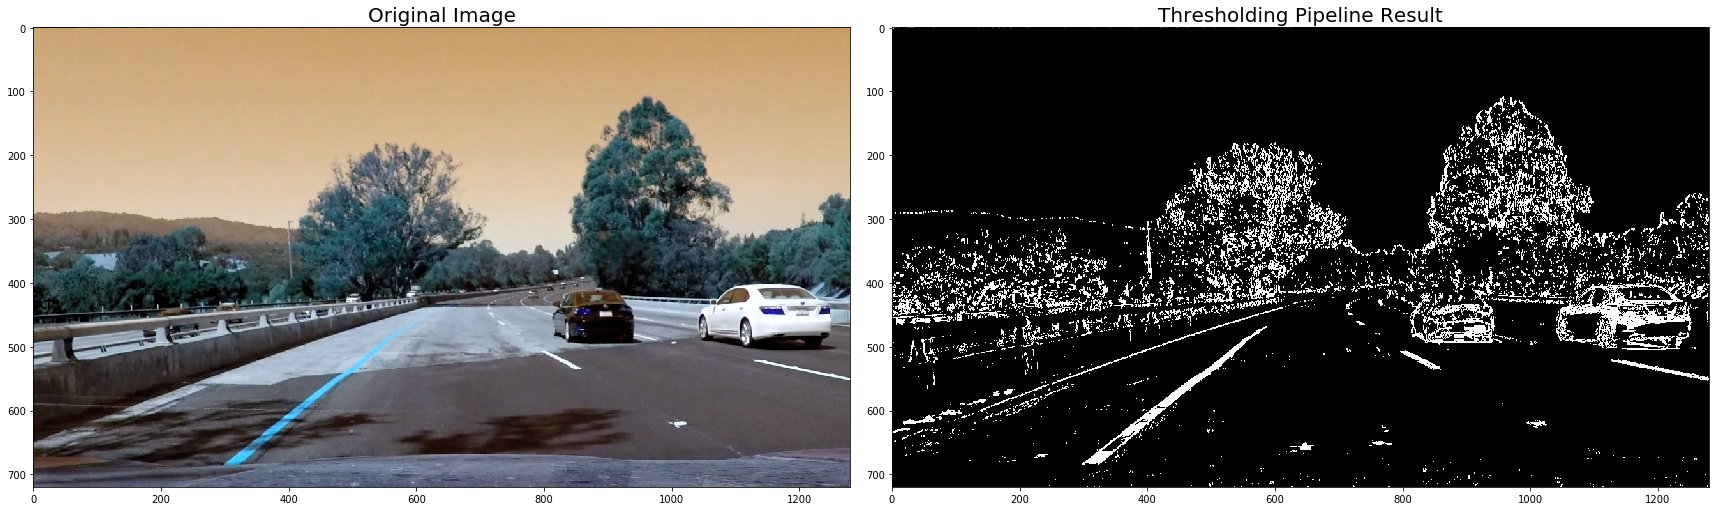

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholding Pipeline Result', fontsize=20)

In [22]:
f.savefig('output_images/thresholding_pipeline_result.jpg')

In [23]:
def corners_unwarp(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = undist.shape[1::-1]
    src = np.float32([[600, 450], [685, 450], 
                      [1100, 720], [200, 720]])
    
    dst = np.float32([[300, 0], [980, 0], 
                      [980, 720], [300, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M ,img_size, flags=cv2.INTER_LINEAR)
    
    cv2.polylines(img,np.int32([src]),True,(255,0,0),thickness=3)
    cv2.polylines(warped,np.int32([dst]),True,(255,0,0),thickness=3)
        
    return img, warped, M, Minv

In [24]:
img = cv2.imread('test_images/straight_lines1.jpg')

Text(0.5,1,'Undistorted and Warped Image')

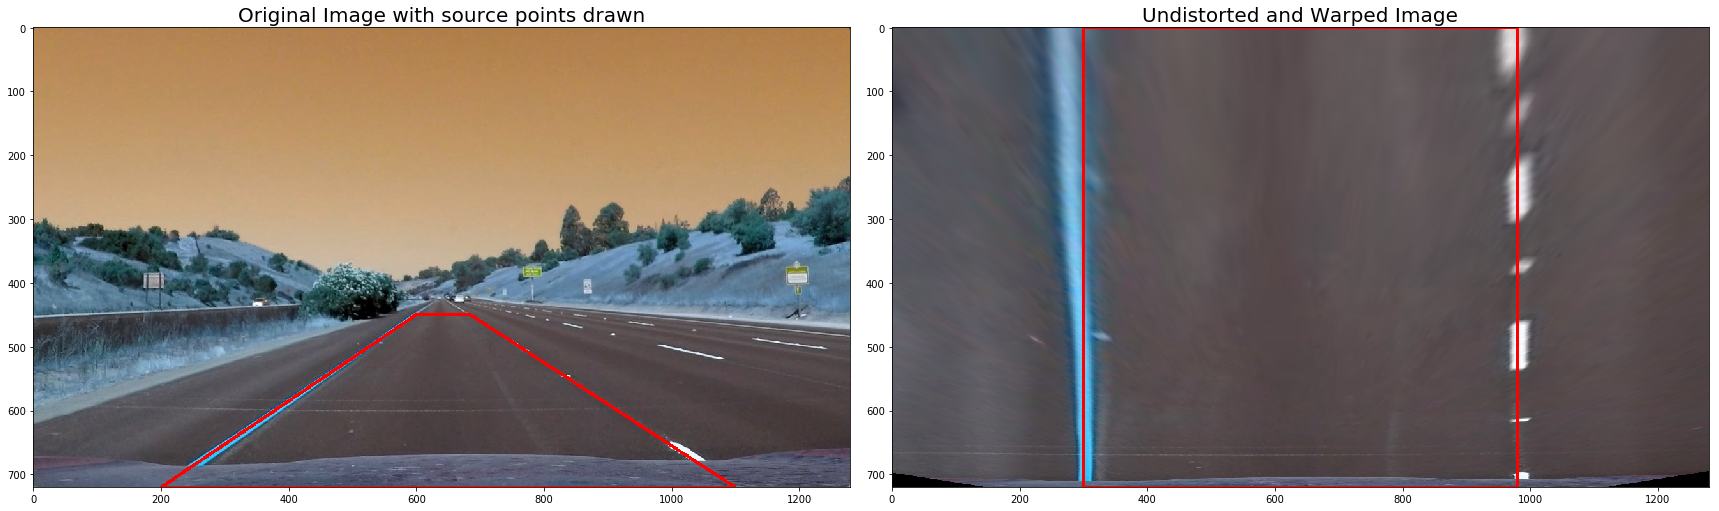

In [25]:
img_src_points, warped_img, perspective_M, Minv = corners_unwarp(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_src_points)
ax1.set_title('Original Image with source points drawn', fontsize=20)
ax2.imshow(warped_img)
ax2.set_title('Undistorted and Warped Image', fontsize=20)

In [26]:
f.savefig('output_images/undistorted_warped_img.jpg')

In [67]:
img = cv2.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary, combined_binary = thresholding_pipeline(undist, s_thresh, sx_thresh)
img_size = combined_binary.shape[::-1]
binary_warped = cv2.warpPerspective(combined_binary, perspective_M ,img_size)

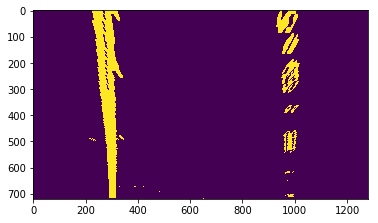

In [68]:
plt.imshow(binary_warped)

In [63]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [64]:
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [65]:
def detect_lane_pixles(binary_warped):
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)
        
    return output, l_points, r_points

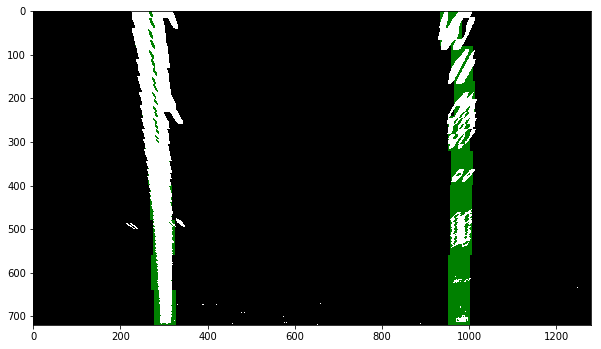

In [69]:
lane_lines, l_points, r_points = detect_lane_pixles(binary_warped)
f = plt.figure(figsize=(10,7))
plt.imshow(lane_lines)

In [70]:
f.savefig('output_images/detect_lane_pixels_convolve.jpg')

In [91]:
def detect_lane_pixels_sw(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img2)
    # Color in left and right line pixels
    out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty, out_img, result

In [59]:
def draw_lane_path(binary, undist, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]),False,(0,0,255),thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]),False,(255,0,),thickness=20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp,Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

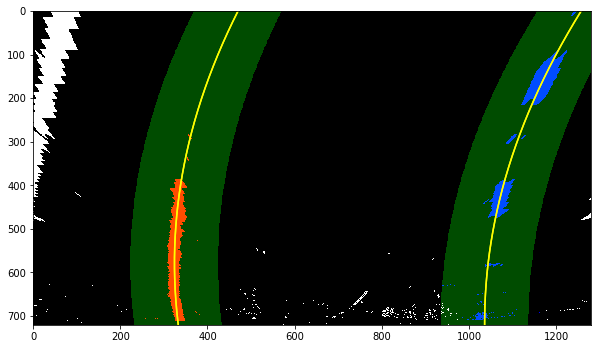

In [92]:
s_thresh=(170, 255)
sx_thresh=(20, 100)
img = cv2.imread("test_images/test1.jpg")
img_size = img.shape[1::-1]
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary, combined_binary = thresholding_pipeline(img, s_thresh, sx_thresh)
binary_warped = cv2.warpPerspective(combined_binary, perspective_M ,img_size, flags=cv2.INTER_LINEAR)
f = plt.figure(figsize=(10,7))
left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty, out_img, result = detect_lane_pixels_sw(binary_warped)

In [72]:
f.savefig('output_images/detect_lane_pixels_sw.jpg')

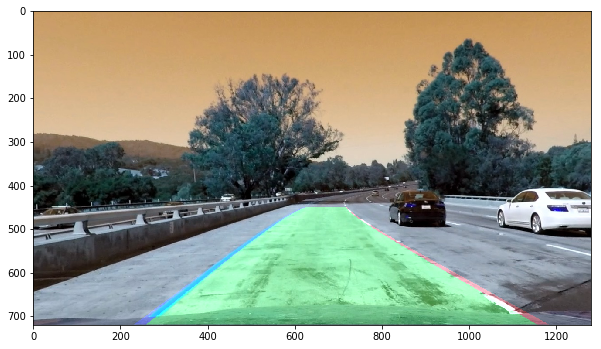

In [60]:
out = draw_lane_path(binary_warped, undist, left_fitx, right_fitx, ploty, Minv)
f = plt.figure(figsize=(10,7))
plt.imshow(out)

In [61]:
f.savefig('output_images/detect_lane_2.jpg')

In [95]:
s_thresh=(170, 255)
sx_thresh=(20, 100)
img = cv2.imread("test_images/test1.jpg")
img_size = img.shape[1::-1]
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary, combined_binary = thresholding_pipeline(img, s_thresh, sx_thresh)
binary_warped = cv2.warpPerspective(combined_binary, perspective_M ,img_size, flags=cv2.INTER_LINEAR)
lane_lines, l_points, r_points = detect_lane_pixles(binary_warped)

Text(0.5,1,'Lane line Detection - Convolution')

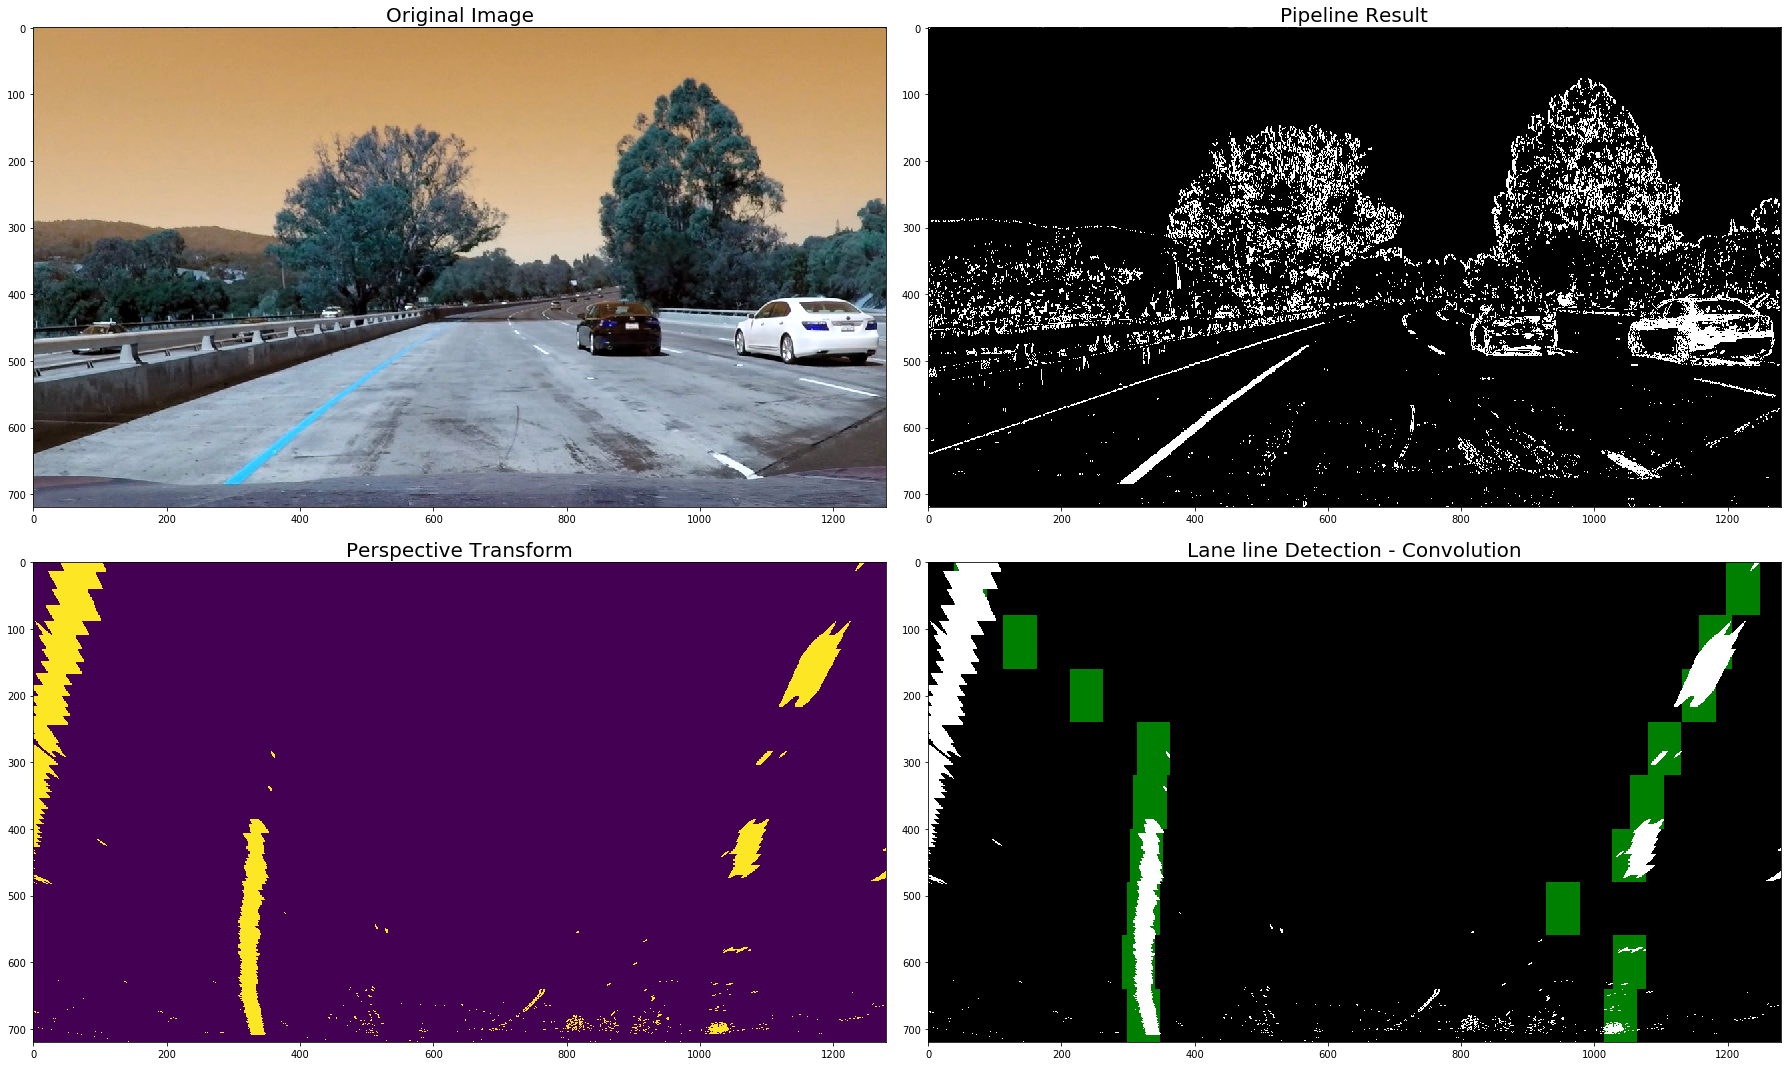

In [96]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=20)

ax3.imshow(binary_warped)
ax3.set_title('Perspective Transform', fontsize=20)

ax4.imshow(lane_lines)
ax4.set_title('Lane line Detection - Convolution', fontsize=20)

In [97]:
f.savefig('output_images/detect_lane_pixels_conv.jpg')

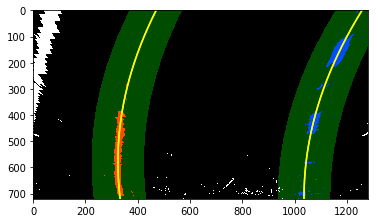

In [98]:
s_thresh=(170, 255)
sx_thresh=(20, 100)
img = cv2.imread("test_images/test1.jpg")
img_size = img.shape[1::-1]
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary, combined_binary = thresholding_pipeline(img, s_thresh, sx_thresh)
binary_warped = cv2.warpPerspective(combined_binary, perspective_M ,img_size, flags=cv2.INTER_LINEAR)
left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty, out_img, result = detect_lane_pixels_sw(binary_warped)

Text(0.5,1,'Lane line Detection - Sliding Window')

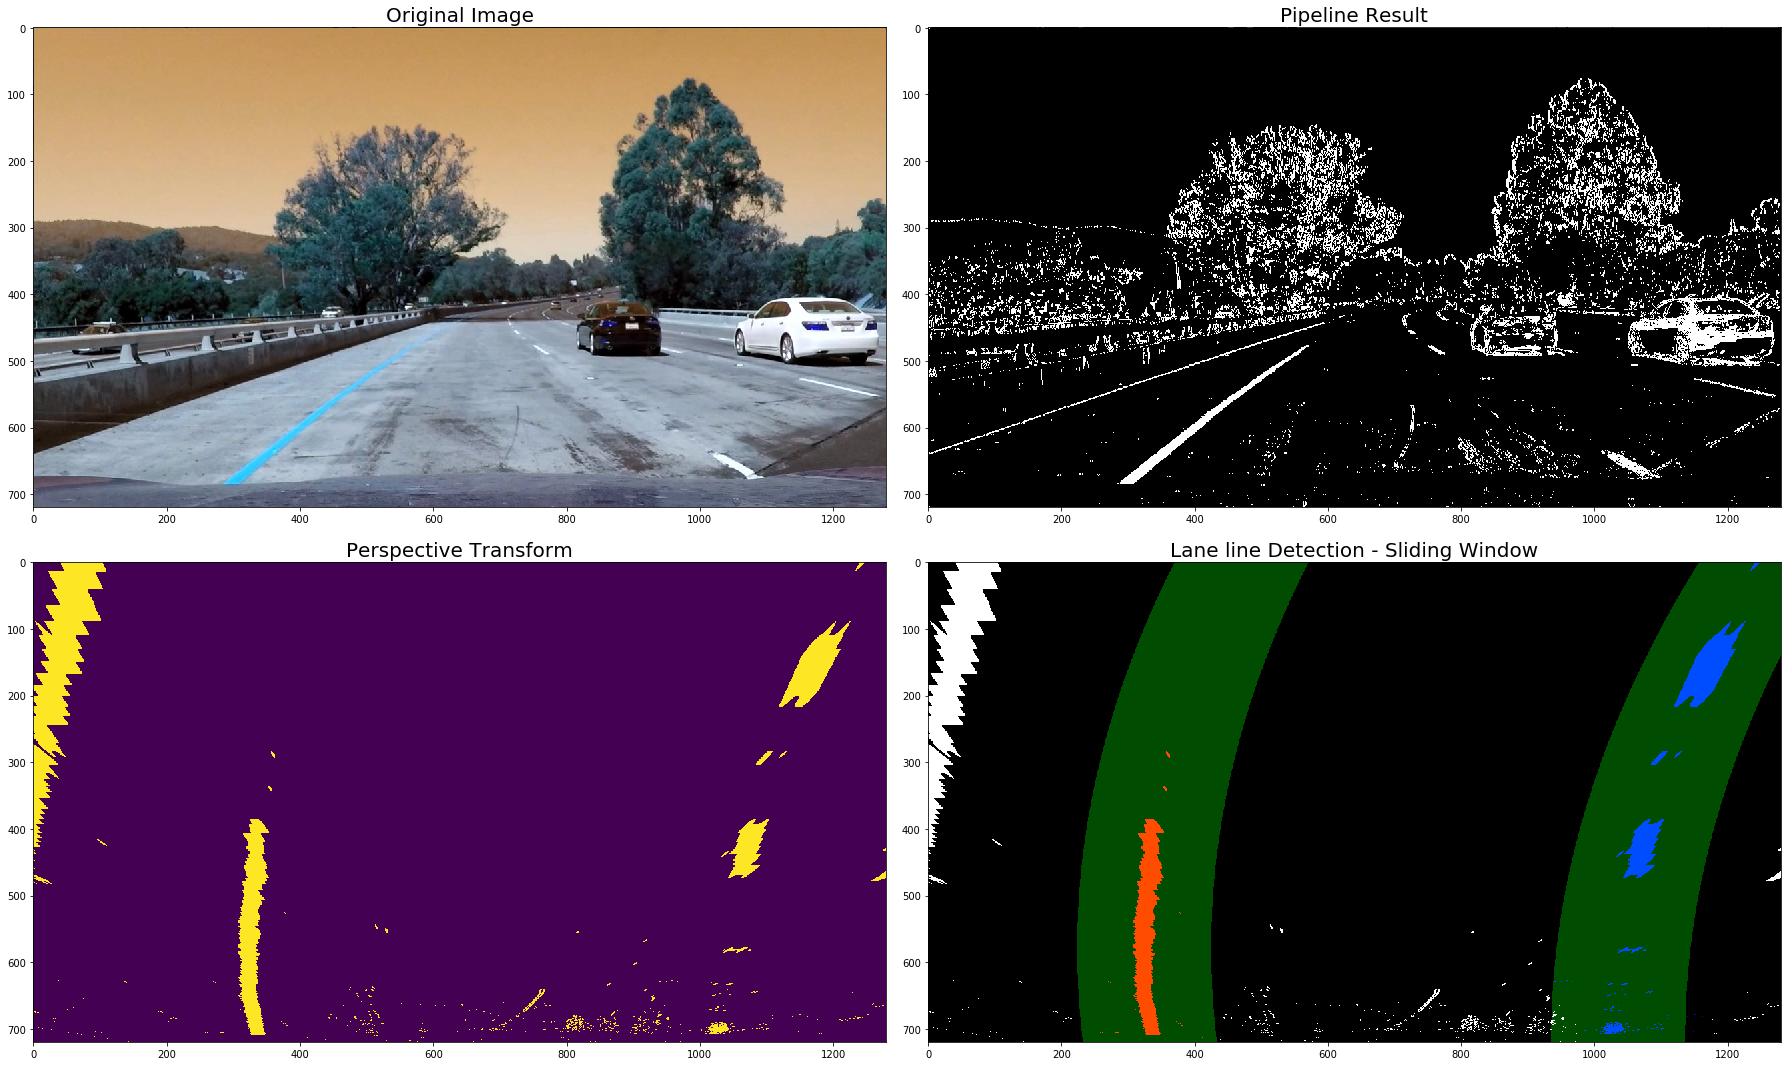

In [99]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=20)

ax3.imshow(binary_warped)
ax3.set_title('Perspective Transform', fontsize=20)

ax4.imshow(result)
ax4.set_title('Lane line Detection - Sliding Window', fontsize=20)

In [100]:
f.savefig('output_images/detect_lane_pixels_sw.jpg')

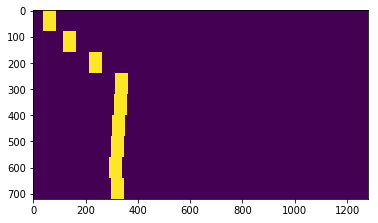

In [161]:
plt.imshow(l_points)

In [162]:
# Again, extract left and right line pixel positions
left_lane_pixels = np.nonzero(l_points)
right_lane_pixels = np.nonzero(r_points)
leftx = left_lane_pixels[1]
lefty = left_lane_pixels[0]
rightx = right_lane_pixels[1]
righty = right_lane_pixels[0]

In [163]:
print(leftx.shape)
print(lefty.shape)
print(rightx.shape)
print(righty.shape)

(36000,)
(36000,)
(36000,)
(36000,)


In [164]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [165]:
ploty = np.linspace(0, 719, num=720)
quadratic_coeff = 3e-4 

In [166]:
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [167]:
left_fitx.shape

(720,)

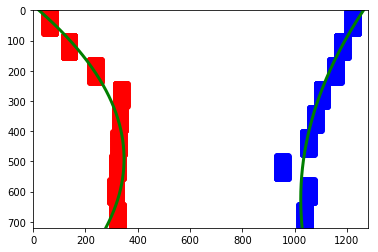

In [168]:
mark_size = 3
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis()

In [84]:
y_eval = np.max(lefty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1189.9288655151279 997.3613576006829


In [169]:
def get_lane_features(left_lane, right_lane):
    left_lane_pixels = np.nonzero(left_lane)
    right_lane_pixels = np.nonzero(right_lane)
    leftx = left_lane_pixels[1]
    lefty = left_lane_pixels[0]
    rightx = right_lane_pixels[1]
    righty = right_lane_pixels[0]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print(right_fitx - left_fitx)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_fitx, right_fitx, left_curverad, right_curverad

In [90]:
left_curverad, right_curverad = get_curvature(l_points, r_points)
print(left_curverad, 'm', right_curverad, 'm')

388.7532845201805 m 323.8118297978986 m


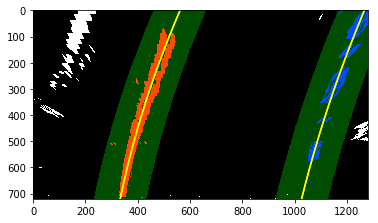

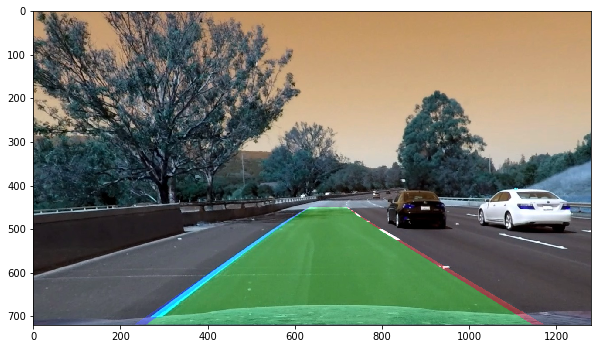

In [79]:
s_thresh=(170, 255)
sx_thresh=(20, 100)
img = cv2.imread("test_images/test6.jpg")
img_size = img.shape[1::-1]
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary, combined_binary = thresholding_pipeline(img, s_thresh, sx_thresh)
binary_warped = cv2.warpPerspective(combined_binary, perspective_M ,img_size, flags=cv2.INTER_LINEAR)
left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty = detect_lane_pixels_sw(binary_warped)
out = draw_lane_path(binary_warped, undist, left_fitx, right_fitx, ploty, Minv)
f = plt.figure(figsize=(10,7))
plt.imshow(out)

In [81]:
f.savefig('output_images/detected_lane_3.jpg')

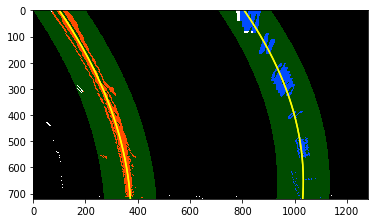

In [102]:
s_thresh=(170, 255)
sx_thresh=(20, 100)
img = cv2.imread("test_images/test2.jpg")
img_size = img.shape[1::-1]
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary, combined_binary = thresholding_pipeline(img, s_thresh, sx_thresh)
binary_warped = cv2.warpPerspective(combined_binary, perspective_M ,img_size, flags=cv2.INTER_LINEAR)
left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty, out_img, result = detect_lane_pixels_sw(binary_warped)
out = draw_lane_path(binary_warped, undist, left_fitx, right_fitx, ploty, Minv)

Text(0.5,1,'Detected lane overlay on original image')

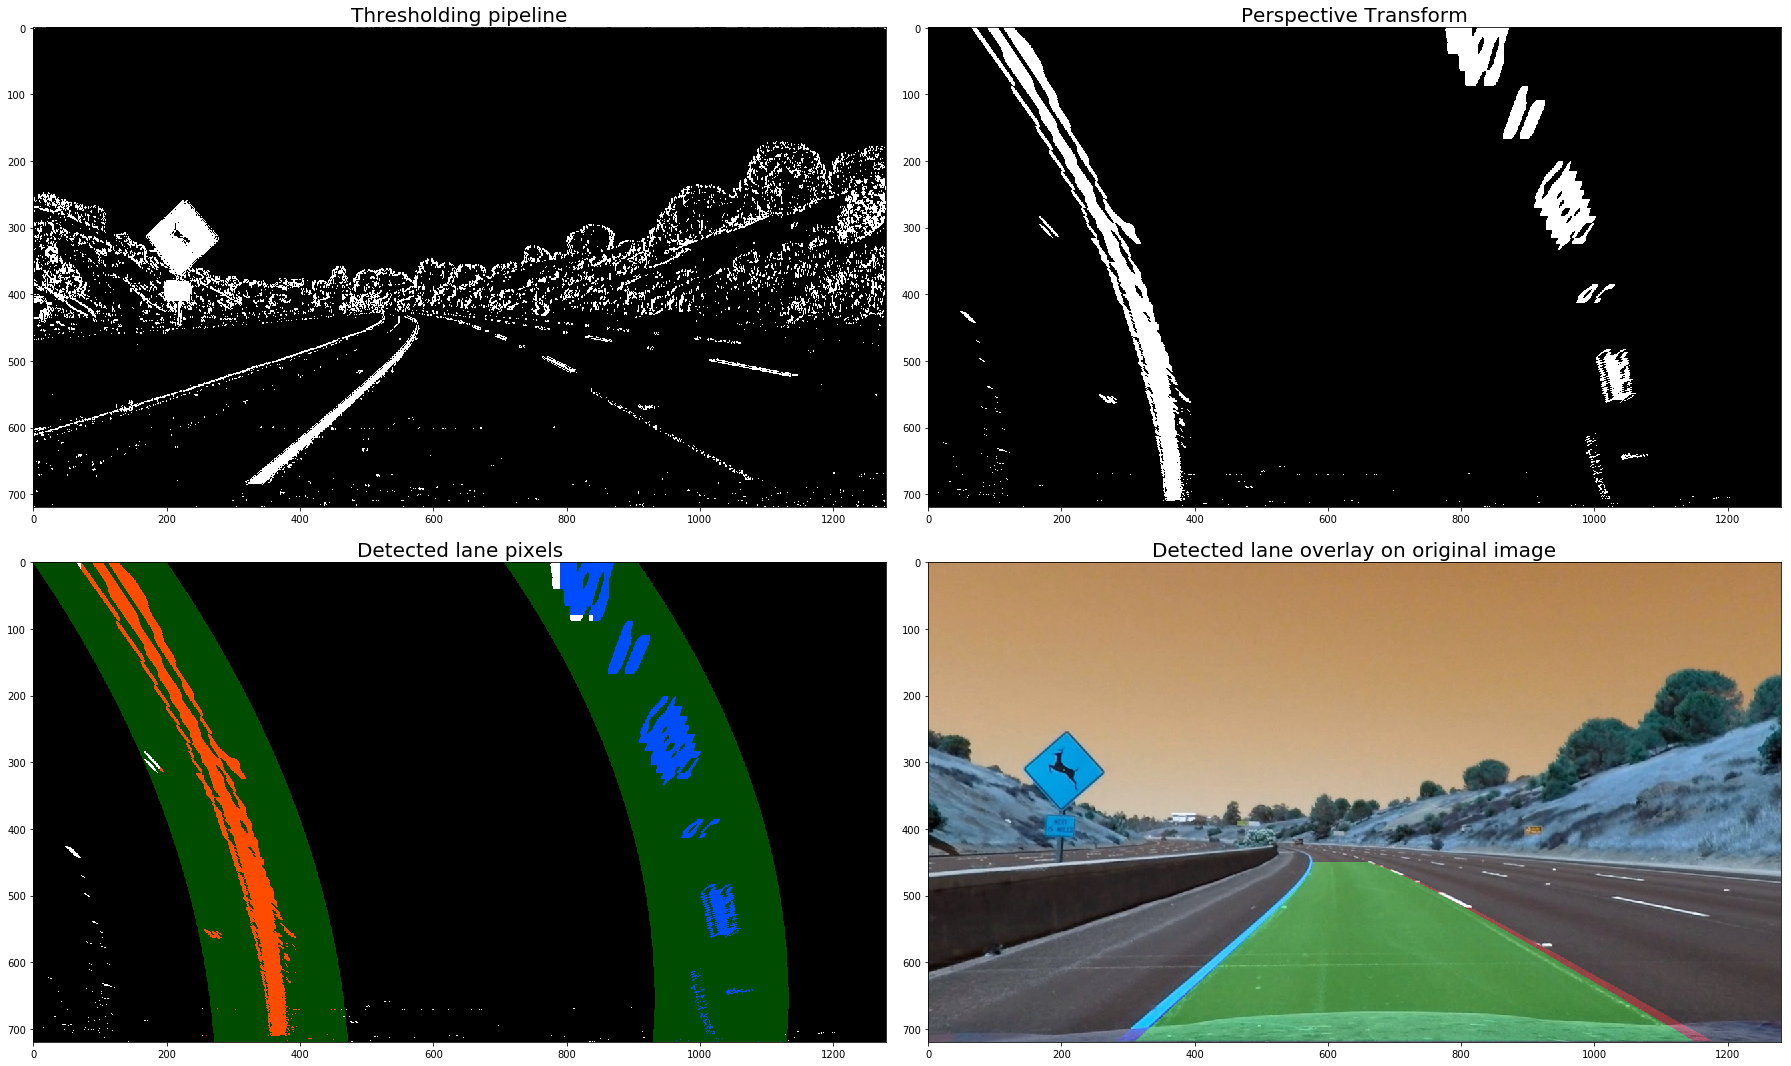

In [103]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Thresholding pipeline', fontsize=20)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Perspective Transform', fontsize=20)

ax3.imshow(result)
ax3.set_title('Detected lane pixels', fontsize=20)

ax4.imshow(out)
ax4.set_title('Detected lane overlay on original image', fontsize=20)

In [104]:
f.savefig('output_images/end-to-end-result.jpg')